# Building and Visualizing word frequencies


In this lab, we will focus on the `build_freqs()` helper function and visualizing a dataset fed into it. In our goal of tweet sentiment analysis, this function will build a dictionary where we can lookup how many times a word appears in the lists of positive or negative tweets. This will be very helpful when extracting the features of the dataset in the week's programming assignment. Let's see how this function is implemented under the hood in this notebook.

## Setup

Let's import the required libraries for this lab: 

In [1]:
import nltk                                             # Python library for NLP
import re
from nltk.corpus import twitter_samples, stopwords      # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt                         # visualization library
import numpy as np                                      # library for scientific computing and matrix operations
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\User/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

#### Import some helper functions that we provided in the utils.py file:
* `process_tweet()`: Cleans the text, tokenizes it into separate words, removes stopwords, and converts words to stems.
* `build_freqs()`: This counts how often a word in the 'corpus' (the entire set of tweets) was associated with a positive label `1` or a negative label `0`. It then builds the `freqs` dictionary, where each key is a `(word,label)` tuple, and the value is the count of its frequency within the corpus of tweets.

In [2]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tokenizer = TweetTokenizer(preserve_case=False,        strip_handles=True,reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation): 
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)




In [3]:
# download the stopwords for the process_tweet function
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load the NLTK sample dataset

As in the previous lab, we will be using the [Twitter dataset from NLTK](http://www.nltk.org/howto/twitter.html#Using-a-Tweet-Corpus).

In [4]:
# select the lists of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# concatenate the lists, 1st part is the positive tweets followed by the negative
tweets = all_positive_tweets + all_negative_tweets

# let's see how many tweets we have
print("Number of tweets: ", len(tweets))

Number of tweets:  10000


Next, we will build an array of labels that matches the sentiments of our tweets.  This data type works pretty much like a regular list but is optimized for computations and manipulation. The `labels` array will be composed of 10000 elements. The first 5000 will be filled with `1` labels denoting positive sentiments, and the next 5000 will be `0` labels denoting the opposite. We can do this easily with a series of operations provided by the `numpy` library:

* `np.ones()` - create an array of 1's
* `np.zeros()` - create an array of 0's
* `np.append()` - concatenate arrays

In [5]:
# make a numpy array representing labels of the tweets
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))

## Dictionaries

In Python, a dictionary is a mutable and indexed collection. It stores items as key-value pairs and uses [hash tables](https://en.wikipedia.org/wiki/Hash_table) underneath to allow practically constant time lookups. In NLP, dictionaries are essential because it enables fast retrieval of items or containment checks even with thousands of entries in the collection.

### Definition

A dictionary in Python is declared using curly brackets. Look at the next example:

In [6]:
dictionary = {'key1': 1, 'key2': 2}

The former line defines a dictionary with two entries. Keys and values can be almost any type ([with a few restriction on keys](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)), and in this case, we used strings. We can also use floats, integers, tuples, etc.

### Adding or editing entries

New entries can be inserted into dictionaries using square brackets. If the dictionary already contains the specified key, its value is overwritten.  

In [7]:
# Add a new entry
dictionary['key3'] = -5

# Overwrite the value of key1
dictionary['key1'] = 0

print(dictionary)

{'key1': 0, 'key2': 2, 'key3': -5}


### Accessing values and lookup keys

Performing dictionary lookups and retrieval are common tasks in NLP. There are two ways to do this: 

* Using square bracket notation: This form is allowed if the lookup key is in the dictionary. It produces an error otherwise.
* Using the [get()](https://docs.python.org/3/library/stdtypes.html#dict.get) method: This allows us to set a default value if the dictionary key does not exist. 

Let us see these in action:

In [8]:
# Square bracket lookup when the key exist
print(dictionary['key2'])

2


When using a square bracket lookup, it is common to use an if-else block to check for containment first (with the keyword `in`) before getting the item. On the other hand, you can use the `.get()` method if you want to set a default value when the key is not found. Let's compare these in the cells below:

In [9]:
# This prints a value
if 'key1' in dictionary:
    print("item found: ", dictionary['key1'])
else:
    print('key1 is not defined')

# Same as what you get with get
print("item found: ", dictionary.get('key1', -1))

item found:  0
item found:  0


In [10]:
# This prints a message because the key is not found
if 'key7' in dictionary:
    print(dictionary['key7'])
else:
    print('key does not exist!')

# This prints -1 because the key is not found and we set the default to -1
print(dictionary.get('key7', -1))

key does not exist!
-1


## Word frequency dictionary

Now that we know the building blocks, let's finally take a look at the **build_freqs()** function in **utils.py**. This is the function that creates the dictionary containing the word counts from each corpus.

```python
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs
```

You can also do the for loop like this to make it a bit more compact:

```python
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1
```

As shown above, each key is a 2-element tuple containing a `(word, y)` pair. The `word` is an element in a processed tweet while `y` is an integer representing the corpus: `1` for the positive tweets and `0` for the negative tweets. The value associated with this key is the number of times that word appears in the specified corpus. For example: 

``` 
# "followfriday" appears 25 times in the positive tweets
('followfriday', 1.0): 25

# "shame" appears 19 times in the negative tweets
('shame', 0.0): 19 
```

Now, it is time to use the dictionary returned by the `build_freqs()` function. First, let us feed our `tweets` and `labels` lists then print a basic report:

In [11]:
from collections import defaultdict

def build_freqs(tweets, labels):
    """
    Builds a frequency dictionary mapping (word, sentiment) pairs to their frequencies.

    Args:
        tweets (list of str): List of tweets.
        labels (list of int): List of corresponding labels (e.g., 1 for positive, 0 for negative).

    Returns:
        dict: A dictionary mapping (word, sentiment) tuples to their frequencies.
    """
    freqs = defaultdict(int)

    # Iterate through each tweet and its corresponding label
    for tweet, label in zip(tweets, labels):
        # Tokenize the tweet into words
        words = tweet.split()  # Simple whitespace tokenization
        for word in words:
            # Update the frequency dictionary
            freqs[(word, label)] += 1

    return freqs

In [12]:
# create frequency dictionary
freqs = build_freqs(tweets, labels)

# check data type
print(f'type(freqs) = {type(freqs)}')

# check length of the dictionary
print(f'len(freqs) = {len(freqs)}')

type(freqs) = <class 'collections.defaultdict'>
len(freqs) = 32012


Now print the frequency of each word depending on its class.

In [13]:
print(freqs)

defaultdict(<class 'int'>, {('#FollowFriday', np.float64(1.0)): 25, ('@France_Inte', np.float64(1.0)): 1, ('@PKuchly57', np.float64(1.0)): 1, ('@Milipol_Paris', np.float64(1.0)): 1, ('for', np.float64(1.0)): 747, ('being', np.float64(1.0)): 57, ('top', np.float64(1.0)): 27, ('engaged', np.float64(1.0)): 7, ('members', np.float64(1.0)): 10, ('in', np.float64(1.0)): 477, ('my', np.float64(1.0)): 481, ('community', np.float64(1.0)): 29, ('this', np.float64(1.0)): 242, ('week', np.float64(1.0)): 62, (':)', np.float64(1.0)): 3272, ('@Lamb2ja', np.float64(1.0)): 1, ('Hey', np.float64(1.0)): 43, ('James!', np.float64(1.0)): 2, ('How', np.float64(1.0)): 23, ('odd', np.float64(1.0)): 1, (':/', np.float64(1.0)): 5, ('Please', np.float64(1.0)): 21, ('call', np.float64(1.0)): 24, ('our', np.float64(1.0)): 129, ('Contact', np.float64(1.0)): 2, ('Centre', np.float64(1.0)): 1, ('on', np.float64(1.0)): 307, ('02392441234', np.float64(1.0)): 1, ('and', np.float64(1.0)): 648, ('we', np.float64(1.0)): 14

Unfortunately, this does not help much to understand the data. It would be better to visualize this output to gain better insights.

## Table of word counts

We will select a set of words that we would like to visualize. It is better to store this temporary information in a table that is very easy to use later.

In [14]:
# select some words to appear in the report. we will assume that each word is unique (i.e. no duplicates)
keys = ['happi', 'merri', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti',
        '❤', ':)', ':(', '😒', '😬', '😄', '😍', '♛',
        'song', 'idea', 'power', 'play', 'magnific']

# list representing our table of word counts.
# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
data = []

# loop through our selected words
for word in keys:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    # append the word counts to the table
    data.append([word, pos, neg])
    
data

[['happi', 0, 0],
 ['merri', 0, 0],
 ['nice', 77, 15],
 ['good', 150, 72],
 ['bad', 15, 50],
 ['sad', 3, 95],
 ['mad', 1, 6],
 ['best', 40, 17],
 ['pretti', 0, 0],
 ['❤', 2, 2],
 [':)', 3272, 0],
 [':(', 1, 3795],
 ['😒', 1, 0],
 ['😬', 0, 1],
 ['😄', 0, 0],
 ['😍', 1, 0],
 ['♛', 0, 0],
 ['song', 9, 17],
 ['idea', 15, 9],
 ['power', 2, 5],
 ['play', 16, 22],
 ['magnific', 0, 0]]

We can then use a scatter plot to inspect this table visually. Instead of plotting the raw counts, we will plot it in the logarithmic scale to take into account the wide discrepancies between the raw counts (e.g. `:)` has 3691 counts in the positive while only 2 in the negative). The red line marks the boundary between positive and negative areas. Words close to the red line can be classified as neutral. 

c:\Users\User\miniconda3\envs\nlp-vector-classification\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


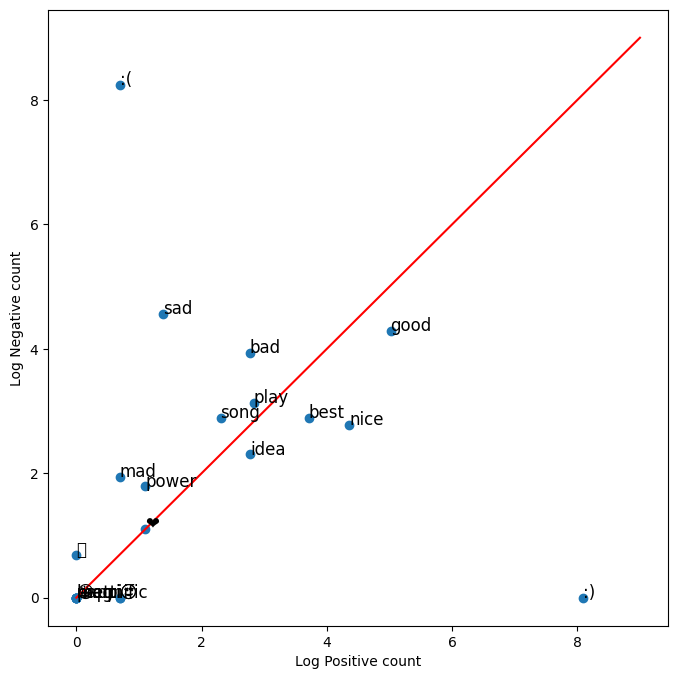

In [15]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

This chart is straightforward to interpret. It shows that emoticons `:)` and `:(` are very important for sentiment analysis. Thus, we should not let preprocessing steps get rid of these symbols!

Furthermore, what is the meaning of the crown symbol? It seems to be very negative!

### That's all for this lab! We've seen how to build a word frequency dictionary and this will come in handy when extracting the features of a list of tweets. Next up, we will be reviewing Logistic Regression. Keep it up!